# Example: Treasury Bill Pricing, Interest Rate Risk, and Term to Maturity

Malkiel proposed five theorems that govern the price of fixed-income debt securities, e.g., Treasury Bills, Notes, and Bonds, as a function of the duration and yield values:

> [Malkiel, B. G. (1962). Expectations, Bond Prices, and the Term Structure of Interest Rates. The Quarterly Journal of Economics, 76(2), 197–218. https://doi.org/10.2307/1880816](https://www.jstor.org/stable/1880816)

In this example, you will develop a simulation test of the second of the five theorems:

> __Theorem 2__: For a given change in yield from the nominal yield, changes in bond prices are greater the longer the term to maturity

## Learning Objectives
By the end of this example, you will be able to:
- Understand how to price zero-coupon Treasury Bills using discount models
- Compute the sensitivity of T-bill prices to changes in interest rates
- Validate pricing models against real auction data
- Simulate and visualize the impact of interest rate perturbations on short- and long-duration securities
- Interpret results in the context of Malkiel's Theorem 2

## Tasks Overview
* __Task 1__: Compute and verify the price of a random T-bill using auction data
* __Task 2__: Analyze price sensitivity to interest rate changes for different maturities

Let's get started!

___

## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. 

> The [include(...) function](https://docs.julialang.org/en/v1/base/base/#include) is a convenient way to load Julia code from another file. The `Include.jl` file is a Julia file that loads external packages, and various functions that we will use in the exercise. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Otherwise, packages are downloaded and then loaded.

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # this sets up the environment, we'll do this all the time, on everything we do

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

We load the `CSV` dataset using a [local `MyTreasuryBillDataSet()` function](src/Files.jl), which returns the auction data as [a `DataFrame` instance](https://dataframes.juliadata.org/stable/). We store the data in the `dataset::DataFrame` variable.

In [2]:
# Load Treasury Bill auction data from 2025
dataset = MyTreasuryBillDataSet()

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,Investment Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64
1,912797QW0,Bill,4-Week,08/28/2025,09/02/2025,09/30/2025,99.6698,0.04318
2,912797RE9,Bill,8-Week,08/28/2025,09/02/2025,10/28/2025,99.3552,0.0423
3,912797RZ2,Bill,17-Week,08/27/2025,09/02/2025,12/30/2025,98.6712,0.04131
4,912797QE0,Bill,6-Week,08/26/2025,08/28/2025,10/09/2025,99.5088,0.0429
5,912797NL7,Bill,13-Week,08/25/2025,08/28/2025,11/28/2025,98.9522,0.04201
6,912797RU3,Bill,26-Week,08/25/2025,08/28/2025,02/26/2026,98.0208,0.0405
7,912797QV2,Bill,4-Week,08/21/2025,08/26/2025,09/23/2025,99.6656,0.04374
8,912797RD1,Bill,8-Week,08/21/2025,08/26/2025,10/21/2025,99.3436,0.04307
9,912797RY5,Bill,17-Week,08/20/2025,08/26/2025,12/23/2025,98.6612,0.04162


Next, let's set the dimension of our auction dataset in the `number_of_bills` variable:

In [3]:
# Get the total number of T-bills in the dataset
number_of_bills = nrow(dataset);

___

## Task 1: Compute and Verify the Price of a Random Treasury Bill
Before we do any sensitivity calculations, let's double-check our Treasury pricing implementation. 

We compute the price of a random T-bill by building a discounting model in this task. In this case, let's construct an instance of the [`DiscreteCompoundingModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.DiscreteCompoundingModel) and store this discount model in the `discount_model` variable.

> The [`DiscreteCompoundingModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.DiscreteCompoundingModel) has no data associated with it. Instead, it is used [by the Julia multiple dispatch system](https://docs.julialang.org/en/v1/manual/methods/#Methods) so that we call the correct pricing methods later.

Let's build our discount model:

In [4]:
# Create a discrete compounding model for discounting cash flows
discount_model = DiscreteCompoundingModel();

Next, select a bill from the `dataset` by randomly selecting an index from `1...number_of_bills` using the [built-in Julia rand function](https://docs.julialang.org/en/v1/stdlib/Random/#Base.rand):

In [5]:
# Randomly select a T-bill from the dataset for pricing validation
random_bill_index = rand(1:number_of_bills)
println("Selected bill: $(random_bill_index)")

Selected bill: 23


What is the data on this bill?

In [6]:
dataset[random_bill_index,:]

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,Investment Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64
23,912797RG4,Bill,52-Week,08/05/2025,08/07/2025,08/06/2026,96.1982,0.03924


### Check: Verify the computed price of a random T-bill
Next, let's build a zero-coupon Treasury bill model, an instance of [the `MyUSTreasuryZeroCouponBondModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.MyUSTreasuryZeroCouponBondModel) using [a custom `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.build-Tuple{Type{MyUSTreasuryZeroCouponBondModel},%20NamedTuple}). 

> The [`build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.build-Tuple{Type{MyUSTreasuryZeroCouponBondModel},%20NamedTuple}) requires two arguments: the type of thing we want to build, and [a NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) holding data needed to construct the thing we want to build. In this case, we pass the `par` value of the T-bill and the `n` argument, i.e., the number of compounding periods per year. We set the duration `T` and `rate` fields using data from the randomly selected bill, and use the short-cut syntax to compute the price. 

Save the updated model in the `zero_coupon_model` variable. 

In [7]:
# Build a zero-coupon T-bill model using data from the selected bill
zero_coupon_model = build(MyUSTreasuryZeroCouponBondModel, (
    par = 100.0, n = 2, 
        
    ### BEGIN SOLUTION    
    T = dataset[random_bill_index, Symbol("Security Term")] |> String |> securityterm,
    rate =  dataset[random_bill_index, Symbol("Investment Rate")]
    ### END SOLUTION    
        
)) |> discount_model;

Did we get the same price as that recorded at auction?

> __Idea:__ If two values are within some relative tolerance `rtol` of each other, the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) returns `true`; otherwise, it returns `false`. When the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) is combined with the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert), a `false` result generates an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError). Thus, we have a simple test for equality that works well for floating-point numbers.

So, how did we do?

In [8]:
# Validate that our computed price matches the auction price
let
    auction_price = dataset[random_bill_index, :Price];
    computed_price = zero_coupon_model.price
    @assert isapprox(auction_price, computed_price; rtol=1e-4)
end

## Task 2: Compute the sensitivity of the T-bill price to interest rate and term to maturity
In this task, let's test Theorem 2 by simulating prices as a function of interest rate and term to maturity. 
* Create models for two bills $i$ and $j$ from the `dataset`. Bills $i$ and $j$ should have a significant difference in duration, for example, `4 weeks` versus `52 weeks`
* Then simulate how these instruments' prices change as we vary the yield by the same percentage. Assume a $V_{P} = 100$ USD for both instruments and semiannual compounding, i.e., $n = 2$.

### Build a short-duration bill model
Select the index of a random `4-Week` duration treasury bill, and save this index in the variable `i`, and then build [a `MyUSTreasuryZeroCouponBondModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.build-Tuple{Type{MyUSTreasuryCouponSecurityModel},%20NamedTuple}).

> __Filter__: We can select data from `dataset` using [the `filter(...)` method exported by the DataFrames.jl package](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter). The [`filter(...)` method](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) takes a function `func` as its first argument and a data frame `df` as its second argument. It returns a data frame containing only the rows from df for which `func` returns `true.`

Let's pull out a random short duration treasury bill, e.g., a `4-Week` duration:

In [9]:
# Filter dataset for 4-week T-bills and select a random one
short_duration_dataset = filter(Symbol("Security Term") => x-> x == "4-Week", dataset)
i = nrow(short_duration_dataset) |> x-> rand(1:x);
short_duration_dataset[i,:]

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,Investment Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64
4,912797QT7,Bill,4-Week,08/07/2025,08/12/2025,09/09/2025,99.6656,0.04374


Build [an `MyUSTreasuryZeroCouponBondModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.MyUSTreasuryZeroCouponBondModel) to model the randomly selected  `4-Week` treasury bill, save this model in the `short_duration_model` variable, and then compute the price using the short-cut syntax:

In [10]:
# Build model for the selected short-duration T-bill
short_duration_model = build(MyUSTreasuryZeroCouponBondModel, (
    
    ### BEGIN SOLUTION    
    par = 100, n = 2, 
    T = short_duration_dataset[i, Symbol("Security Term")] |> String |> securityterm,
    rate = short_duration_dataset[i, Symbol("Investment Rate")],
    ### END SOLUTION
        
)) |> discount_model; # short cut price calculation

#### Check: Is the short-duration price `similar` to the dataset?

In [11]:
# Extract and validate the price of the short-duration bill
short_duration_price = short_duration_model.price
@assert isapprox(short_duration_price, short_duration_dataset[i,:Price], rtol = 1e-3)

### TODO: Build a long-duration bill model

Select the index of a random `52-Week` duration treasury bill, and save this index in the variable `j`, and then build [a `MyUSTreasuryZeroCouponBondModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.build-Tuple{Type{MyUSTreasuryZeroCouponBondModel},%20NamedTuple}).

In [12]:
# Filter dataset for 52-week T-bills and select a random one
long_duration_dataset = filter(Symbol("Security Term") => x-> x == "52-Week", dataset)
j = nrow(long_duration_dataset) |> x-> rand(1:x);
long_duration_dataset[j,:]

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,Investment Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64
2,912797RF6,Bill,52-Week,07/08/2025,07/10/2025,07/09/2026,96.0314,0.04102


Next, build [a `MyUSTreasuryZeroCouponBondModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.MyUSTreasuryZeroCouponBondModel) to model the random `52-Week` treasury bill and compute the price using the short-cut syntax:

In [13]:
# Build model for the selected long-duration T-bill
long_duration_model = build(MyUSTreasuryZeroCouponBondModel, (
    
    ### BEGIN SOLUTION   
    par = 100, n = 2, 
    T = long_duration_dataset[j, Symbol("Security Term")] |> String |> securityterm,
    rate = long_duration_dataset[j, Symbol("Investment Rate")],
    ### END SOLUTION
        
)) |> discount_model;

#### Check: Is the long-duration price `similar` to the dataset?

In [14]:
# Extract and validate the price of the long-duration bill
long_duration_price = long_duration_model.price
@assert isapprox(long_duration_price, long_duration_dataset[j,:Price], rtol = 1e-3)

Finally, we compute the perturbation array (stored in the `β`-variable) using the [range function](https://docs.julialang.org/en/v1/base/math/#Base.range) in combination with the [Julia pipe |> operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) and [the Julia collect function](https://docs.julialang.org/en/v1/base/collections/#Base.collect-Tuple{Type,%20Any}), which converts a range type to a collection, i.e., an array

In [15]:
# Set up perturbation parameters for interest rate sensitivity analysis
### BEGIN SOLUTION
number_of_samples = 11;
β₁ = 0.8;
β₂ = 1.2;
β = range(β₁, stop = β₂, length = number_of_samples) |> collect;
### END SOLUTION

11-element Vector{Float64}:
 0.8
 0.84
 0.88
 0.92
 0.96
 1.0
 1.04
 1.08
 1.12
 1.16
 1.2

### Compute the change of the short and long-duration prices as a function of the yield 
Compute the price of the short and long-duration notes or bonds using different values for the yield (stored in the `rate` field), and store the results in the `theorem_2_simulation_array` variable. Iterate through each value of the $\beta$ array using a `for` loop. For iteration $i$ of the loop:

* Get a value for the perturbation $\beta_{i}$ from the $\beta$-array, and compute the new effective rate value for each model $\bar{r}_{i} = \beta_{i}\cdot{\bar{r}}$.
* Update the `short_duration_model` and the `long_duration_model` model instances with the new rates (set the `rate` field), and compute the new prices
* Store the $\beta_{i}$ value in column 1, and the percentage difference in price for each instrument in column 2 (short) and column 3 (long) of the `theorem_2_simulation_array`

In [16]:
# Simulate price changes for different interest rate perturbations
theorem_2_simulation_array = let
    
    #  initialize -
    theorem_2_simulation_array = Array{Float64,2}(undef, number_of_samples, 3);

    # Store original rates
    original_short_rate = short_duration_dataset[i, Symbol("Investment Rate")];
    original_long_rate = long_duration_dataset[j, Symbol("Investment Rate")];

    for k ∈ eachindex(β)
        
        β_value = β[k];
        
        ### BEGIN SOLUTION
        short_duration_model.rate = β_value * original_short_rate;
        long_duration_model.rate = β_value * original_long_rate;
        new_short_duration_price = short_duration_model |> discount_model |> x-> x.price
        new_long_duration_price = long_duration_model |> discount_model |> x-> x.price
        
        theorem_2_simulation_array[k,1] = β_value
        theorem_2_simulation_array[k,2] = ((new_short_duration_price - short_duration_price)/short_duration_price)*100
        theorem_2_simulation_array[k,3] = ((new_long_duration_price - long_duration_price)/long_duration_price)*100
        ### END SOLUTION
    end
    theorem_2_simulation_array
end

11×3 Matrix{Float64}:
 0.8    0.0658343   0.80656
 0.84   0.0526414   0.644469
 0.88   0.0394615   0.482768
 0.92   0.0262947   0.321457
 0.96   0.0131408   0.160535
 1.0    0.0         0.0
 1.04  -0.0131279  -0.160149
 1.08  -0.0262428  -0.319913
 1.12  -0.0393448  -0.479294
 1.16  -0.0524339  -0.638293
 1.2   -0.0655101  -0.79691

#### Visualize
`Unhide` the code block below to see how we plotted the short- and long-duration T-bills response to changes in the interest (discount) rate $\bar{r}$.
> __Expectation__: The longer maturity T-bill should be more sensitive to changes in the interest rate (light-gray line) than the shorter duration instrument (black line). Do our simulations support this?

Is that what you see?

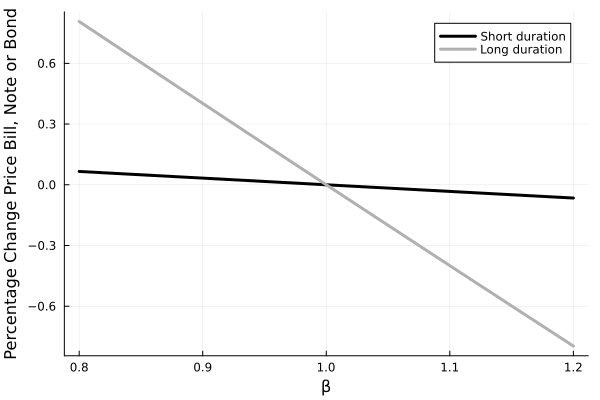

In [ ]:
let
    plot(theorem_2_simulation_array[:,1], theorem_2_simulation_array[:,2], label="Short duration", lw=3, c=:black, 
            xlabel="β", ylabel="Percentage Change Price Bill, Note or Bond")
    plot!(theorem_2_simulation_array[:,1], theorem_2_simulation_array[:,3], label="Long duration", lw=3, c=:gray69, 
            xlabel="β", ylabel="Percentage Change Price Bill, Note or Bond")
end

## Discussion: Does your simulation result make sense?
If your simulation was implemented correctly, the longer duration T-bill was more sensitive to changes in the nominal effective interest rate $\bar{r}$.

1. Compare the percentage change in the price of the short- and long-duration T-bills at $\beta = 0.9$; the longer-duration instrument should have a larger percentage change in price. Similarly, for $\beta = 1.1$, the price of the longer-duration instrument should show a bigger change relative to the short-duration T-bill.

2. Intuitively, why might you expect __Theorem 2__ to be true?

3. Who is more at risk in a variable interest rate environment, a short-term or long-term bondholder?

___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.